_The training processes in this notebook have been folded to provide better readability._

# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

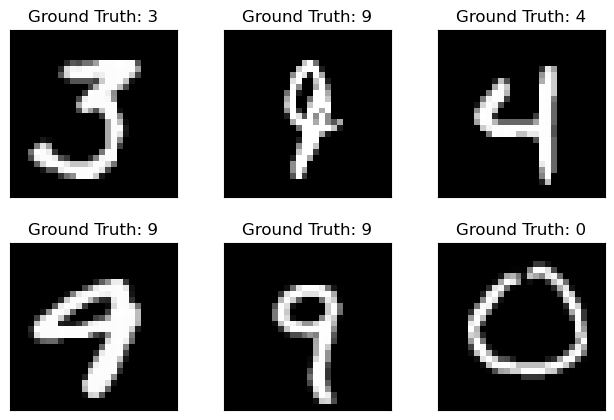

In [5]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) # a dense layer that maps input features to output features

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out) # log prob

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [41]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [42]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [43]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [44]:
network_accuracies = []

In [45]:
! mkdir -p results

In [46]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [47]:
train(1)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_81600/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.429462
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.386845
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.258237
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.992214
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.887418
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.957998
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.729396
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.748037
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.673301
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.638524
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.499379
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.573776
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.589812
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.463606
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.397141
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.240399
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.265620
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.153471
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.079251
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.227800
Train Epoch: 1 [12800/60000 (

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [48]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    network_accuracies.append(accuracy.item()) # this line was added to record the test accuracies
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * accuracy)
    )

In [49]:
test()

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_81600/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob
/Users/gxy/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5718, Accuracy: 8596/10000 (86%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [50]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_81600/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.695721
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.556152
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.350804
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.543070
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.495768
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.519578
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.516223
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.435592
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.482973
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.552708
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.529158
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.415500
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.683600
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.477282
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.600633
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.607560
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.413780
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.680352
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.565555
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.526516
Train Epoch: 2 [12800/60000 (

In [53]:
network_accuracies

[0.8596000075340271,
 0.8808000087738037,
 0.88919997215271,
 0.8952999711036682,
 0.8995000123977661]

## Model performance

Finally, we can inspect the results.

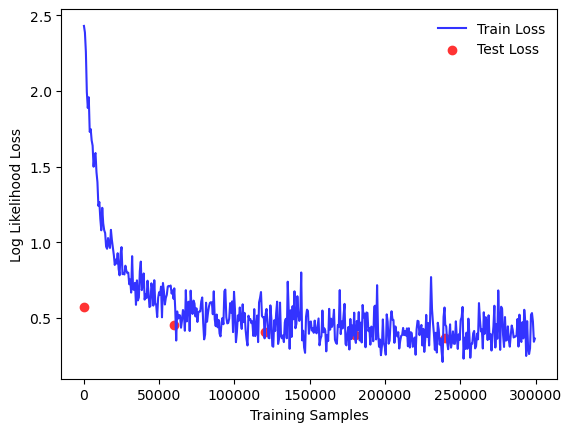

In [54]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [55]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_81600/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


**Challenge:** Can you explain why we are using `torch.no_grad()`?

- This is a function that disables gradient calculation during the evaluation phase. This step helps to prevent the update of model parameters during validation or testing, which helps reduce memory usage.

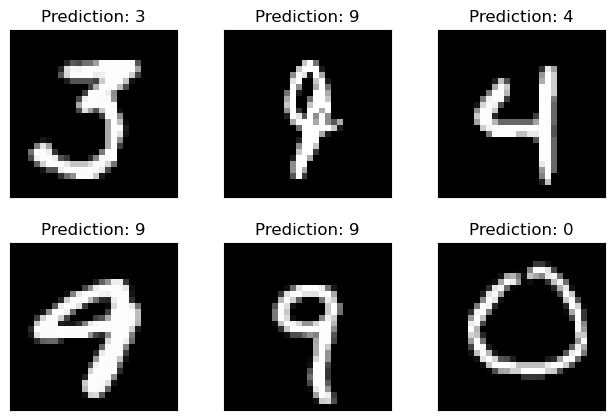

In [57]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
# fig

Note:

- `output` shape: [batch_size, num_classes]
- each row correspond to one image, and the values are log probability for each class. 

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

In [58]:
predictions = output.data.max(1, keepdim=True)[1]

In [21]:
# Check for misclassification
missclassification = []
for i in range(len(example_data)):
    if predictions[i].item() != example_targets[i].item():  
        missclassification.append(i)

In [22]:
len(missclassification)

95

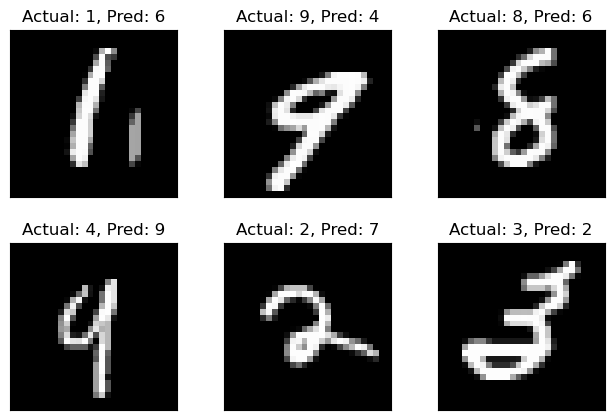

In [23]:
fig = pl.figure()
for j in range(6):
    i = missclassification[j]
    pl.subplot(2, 3, j + 1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Actual: {}, Pred: {}".format(example_targets[i].item(), predictions[i].item()))
    pl.xticks([])
    pl.yticks([])

pl.show()

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [24]:
! ls results

model_iteration-1.pth      optimizer_iteration-1.pth
model_iteration-10.pth     optimizer_iteration-10.pth
model_iteration-2.pth      optimizer_iteration-2.pth
model_iteration-3.pth      optimizer_iteration-3.pth
model_iteration-4.pth      optimizer_iteration-4.pth
model_iteration-5.pth      optimizer_iteration-5.pth
model_iteration-6.pth      optimizer_iteration-6.pth
model_iteration-7.pth      optimizer_iteration-7.pth
model_iteration-8.pth      optimizer_iteration-8.pth
model_iteration-9.pth      optimizer_iteration-9.pth


To load a model:

In [25]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_66660/511041913.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("results/model_i

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [26]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [27]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

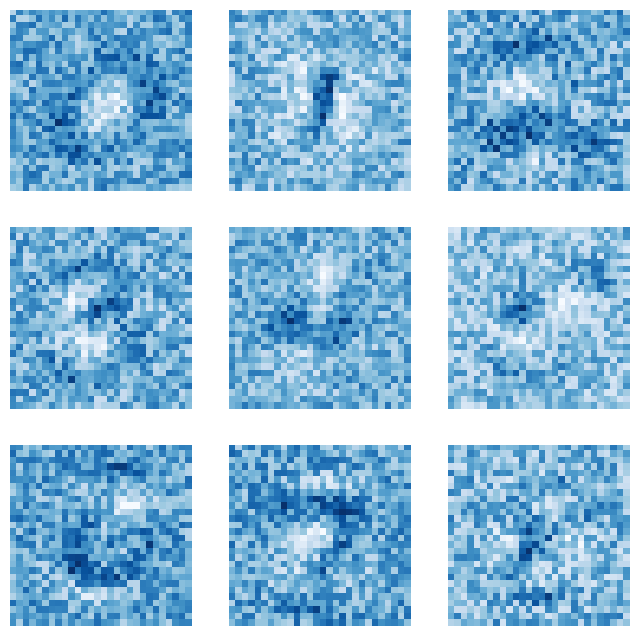

In [28]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [29]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_66660/1021501824.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer_state_dict = torch.load("results/op

In [30]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

In [31]:
optimizer_state_dict['state']

{0: {'momentum_buffer': tensor([[-1.3096e-03, -1.3096e-03, -1.3096e-03,  ..., -1.3096e-03,
           -1.3096e-03, -1.3096e-03],
          [ 9.4556e-05,  9.4556e-05,  9.4556e-05,  ...,  9.4556e-05,
            9.4556e-05,  9.4556e-05],
          [ 7.4225e-03,  7.4225e-03,  7.4225e-03,  ...,  7.4225e-03,
            7.4225e-03,  7.4225e-03],
          ...,
          [-3.4549e-04, -3.4549e-04, -3.4549e-04,  ..., -3.4549e-04,
           -3.4549e-04, -3.4549e-04],
          [ 5.1118e-03,  5.1118e-03,  5.1118e-03,  ...,  5.1118e-03,
            5.1118e-03,  5.1118e-03],
          [-4.0428e-03, -4.0428e-03, -4.0428e-03,  ..., -4.0428e-03,
           -4.0428e-03, -4.0428e-03]])},
 1: {'momentum_buffer': tensor([ 3.0871e-03, -2.2290e-04, -1.7497e-02, -1.0883e-02,  1.6721e-02,
           3.4171e-05,  1.0465e-02,  8.1442e-04, -1.2050e-02,  9.5301e-03])}}

In [32]:
optimizer_state_dict['param_groups']

[{'lr': 0.001,
  'momentum': 0.1,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'fused': None,
  'params': [0, 1]}]

**Challenge:** Can you make sense of the data in this dictionary?

- The `state` in this dictionary stores momentum buffers for each parameters in the network (in this case, 0 and 1). It stores the exponentially decaying sum of past gradients. 
- The `param_groups` stores the parameter groups used by the optimizer, including potentially different hyperparameters.

## Final challenges

#### 1. What happens if you use only 10% of the available training data? Plot the difference in performance of the network.

My intuition is that the model trained on only 10% of the training data won't perform as the one trained on all training data. The model may not be able to learn enough details or variations due to the smaller size of training data, thus has less capability to generalize to unseen data.

In [61]:
len(train_loader.dataset)

60000

In [62]:
# get subset of training data
size = int(0.1 * len(train_loader.dataset))
print(size)
train_loader_subset = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_loader.dataset, range(size)),
    batch_size=batch_size_train,
    shuffle=True
)

6000


In [65]:
# store the performance of the full dataset
train_losses_full = train_losses
test_losses_full = test_losses
test_accuracies_full = network_accuracies

In [66]:
# build new model for partial training data
network_partial = FeedforwardNeuralNetModel()
optimizer_partial = optim.SGD(network_partial.parameters(), lr=learning_rate, momentum=momentum)

n_epochs = 5

train_losses_partial = []
train_counter_partial = []
test_losses_partial = []
test_counter_partial = [i*len(train_loader_subset.dataset) for i in range(n_epochs + 1)]

network_partial_accuracies = []

In [67]:
! mkdir -p results_subset

In [68]:
def train_partial(epoch):
    network_partial.train()
    for batch_idx, (data, target) in enumerate(train_loader_subset):
        optimizer_partial.zero_grad() # clears gradients
        output_partial = network_partial(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output_partial, target)
        loss.backward()
        
        optimizer_partial.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_subset.dataset),
                100. * batch_idx / len(train_loader_subset), loss.item())
            )
            train_losses_partial.append(loss.item())
            train_counter_partial.append((batch_idx*64) + ((epoch-1)*len(train_loader_subset.dataset)))
            torch.save(network_partial.state_dict(), f'./results_subset/model_iteration-{epoch}.pth')
            torch.save(optimizer_partial.state_dict(), f'./results_subset/optimizer_iteration-{epoch}.pth')

In [70]:
def test_partial():
    network_partial.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output_partial = network_partial(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output_partial, target, size_average=False).item()
            pred = output_partial.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    accuracy = correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_losses_partial.append(test_loss)
    network_partial_accuracies.append(accuracy.item()) # this line was added to record the test accuracies
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * accuracy)
    )

In [71]:
# train the model on partial training data
for epoch in range(1, n_epochs + 1): 
  train_partial(epoch)
  test_partial()

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_81600/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.476084
Train Epoch: 1 [640/6000 (11%)]	Loss: 2.405484
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.217009
Train Epoch: 1 [1920/6000 (32%)]	Loss: 2.052157
Train Epoch: 1 [2560/6000 (43%)]	Loss: 2.032157
Train Epoch: 1 [3200/6000 (53%)]	Loss: 1.927128
Train Epoch: 1 [3840/6000 (64%)]	Loss: 1.751475
Train Epoch: 1 [4480/6000 (74%)]	Loss: 1.778577
Train Epoch: 1 [5120/6000 (85%)]	Loss: 1.561551
Train Epoch: 1 [5760/6000 (96%)]	Loss: 1.469309


/Users/gxy/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.5676, Accuracy: 5999/10000 (60%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 1.551242
Train Epoch: 2 [640/6000 (11%)]	Loss: 1.505968
Train Epoch: 2 [1280/6000 (21%)]	Loss: 1.457743
Train Epoch: 2 [1920/6000 (32%)]	Loss: 1.460498
Train Epoch: 2 [2560/6000 (43%)]	Loss: 1.425626
Train Epoch: 2 [3200/6000 (53%)]	Loss: 1.268772
Train Epoch: 2 [3840/6000 (64%)]	Loss: 1.228720
Train Epoch: 2 [4480/6000 (74%)]	Loss: 1.317627
Train Epoch: 2 [5120/6000 (85%)]	Loss: 1.163259
Train Epoch: 2 [5760/6000 (96%)]	Loss: 1.097862

Test set: Avg. loss: 1.1690, Accuracy: 7281/10000 (73%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 1.188253
Train Epoch: 3 [640/6000 (11%)]	Loss: 1.097039
Train Epoch: 3 [1280/6000 (21%)]	Loss: 1.162622
Train Epoch: 3 [1920/6000 (32%)]	Loss: 1.201068
Train Epoch: 3 [2560/6000 (43%)]	Loss: 1.043133
Train Epoch: 3 [3200/6000 (53%)]	Loss: 1.038062
Train Epoch: 3 [3840/6000 (64%)]	Loss: 1.174242
Train Epoch: 3 [4480/6000 (74%)]	Loss: 0.898120
Train Epoch: 3 [5120/6000 (85%

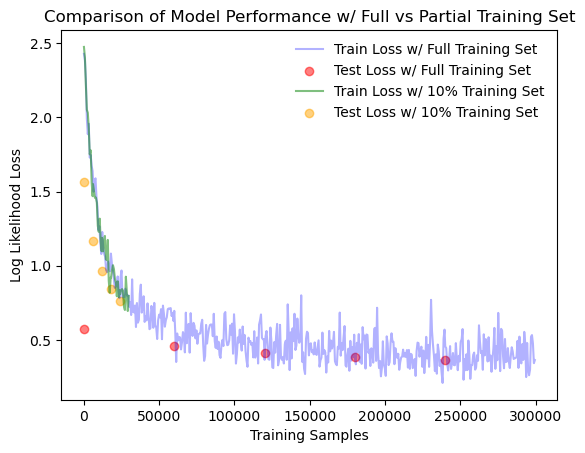

In [79]:
# plot the training and testing losses of the two rounds together
fig = pl.figure()
pl.plot(train_counter, train_losses_full, color="blue", alpha=0.3)
pl.scatter(test_counter[:-1], test_losses_full, color="red", alpha=0.5)
pl.plot(train_counter_partial, train_losses_partial, color="green", alpha=0.5)
pl.scatter(test_counter_partial[:-1], test_losses_partial, color="orange", alpha=0.5)


pl.legend(['Train Loss w/ Full Training Set', 'Test Loss w/ Full Training Set', 'Train Loss w/ 10% Training Set', 'Test Loss w/ 10% Training Set'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/ Full vs Partial Training Set")

pl.show()

According to the plot, as the number of training samples increases, the training loss decreases. The dots showcase how well the models generalize to unseen data. For the model trained on the full training set, the test loss tend to converge to lower values, while the model trained on partial training set have higher test losses. In summary, using more training data improves model performance by reducing both training and testing losses. 

<Figure size 640x480 with 0 Axes>

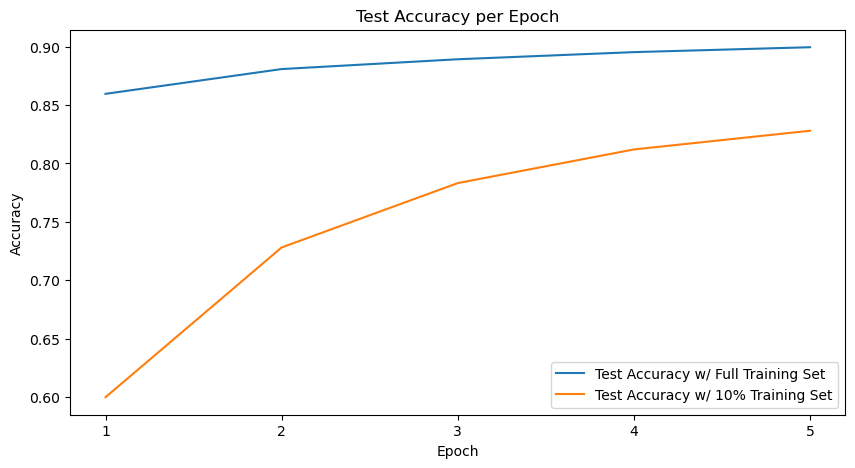

In [78]:
# plot the test accuracies of the two models
fig = pl.figure()
pl.figure(figsize=(10, 5))
epochs = [int(i) for i in range(1, n_epochs + 1)]
pl.plot(epochs, network_accuracies, label='Test Accuracy w/ Full Training Set')
pl.plot(epochs, network_partial_accuracies, label='Test Accuracy w/ 10% Training Set')
pl.xlabel('Epoch')
pl.ylabel('Accuracy')
pl.title('Test Accuracy per Epoch')
pl.xticks(epochs)
pl.legend()
pl.show()

pl.show()

The model trained on the full training set consistently outperforms the model trained on 10% training set in terms of test accuracy across all epochs. This aligns with my intuition that a larger training set provides more information for the model to learn and thus lead to better model performance and generalization.

#### 2. What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?

My intuition is that the model's performance would decrease when prediction the samples with label 5, and would remain roughly the same for the samples with other labels (which means the difference is not homogenous). Since less training data may lead to worse performance as shown in the last question, decreasing the number of training data on samples with label 5 may hurt the model's performance on this particular group of samples. This change of the training data structure may not influence the model's performance on other label groups because they still have the same number of training samples.

In [43]:
import random
from torch.utils.data import Subset

In [44]:
random.seed(42)
# select the indices to remove
indices_label_5 = [i for i, (_, label) in enumerate(train_loader.dataset) if label == 5]
indices_to_remove = random.sample(indices_label_5, int(0.8*len(indices_label_5)))

In [45]:
# count of labels in training set
label_count = {}
for j in range(10):
    label_count[j] = len([i for i, (_, label) in enumerate(train_loader.dataset) if label == j])
label_count

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [46]:
indices_to_keep = [i for i in range(len(train_loader.dataset)) if i not in indices_to_remove]
dataset_remove_samples = Subset(train_loader.dataset, indices_to_keep)
train_loader_remove_samples = torch.utils.data.DataLoader(
    dataset_remove_samples,
    batch_size=batch_size_train,
    shuffle=True)

In [47]:
network_remove_samples = FeedforwardNeuralNetModel()
optimizer_remove_samples = optim.SGD(network_remove_samples.parameters(), lr=0.001, momentum=0.9)

n_epochs = 5

train_losses_remove_samples = []
train_counter_remove_samples = []
test_losses_remove_samples = []
test_counter_remove_samples = [i*len(train_loader_remove_samples.dataset) for i in range(n_epochs + 1)]

In [48]:
! mkdir -p results_remove_samples

In [49]:
def train_remove_samples(epoch):
    network_remove_samples.train()
    for batch_idx, (data, target) in enumerate(train_loader_remove_samples):
        optimizer_remove_samples.zero_grad() # clears gradients
        output_remove_samples = network_remove_samples(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output_remove_samples, target)
        loss.backward()
        
        optimizer_remove_samples.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_remove_samples.dataset),
                100. * batch_idx / len(train_loader_remove_samples), loss.item())
            )
            train_losses_remove_samples.append(loss.item())
            train_counter_remove_samples.append((batch_idx*64) + ((epoch-1)*len(train_loader_remove_samples.dataset)))
            torch.save(network_remove_samples.state_dict(), f'./results_remove_samples/model_iteration-{epoch}.pth')
            torch.save(optimizer_remove_samples.state_dict(), f'./results_remove_samples/optimizer_iteration-{epoch}.pth')

In [50]:
def test_remove_samples():
    network_remove_samples.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output_remove_samples = network_remove_samples(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output_remove_samples, target, size_average=False).item()
            pred = output_remove_samples.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_remove_samples.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [51]:
for epoch in range(1, n_epochs + 1): 
  train_remove_samples(epoch)
  test_remove_samples()

Train Epoch: 1 [0/55664 (0%)]	Loss: 2.580676
Train Epoch: 1 [640/55664 (1%)]	Loss: 2.009605


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_66660/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Train Epoch: 1 [1280/55664 (2%)]	Loss: 1.185297
Train Epoch: 1 [1920/55664 (3%)]	Loss: 1.116643
Train Epoch: 1 [2560/55664 (5%)]	Loss: 0.968952
Train Epoch: 1 [3200/55664 (6%)]	Loss: 0.899724
Train Epoch: 1 [3840/55664 (7%)]	Loss: 0.506727
Train Epoch: 1 [4480/55664 (8%)]	Loss: 0.603799
Train Epoch: 1 [5120/55664 (9%)]	Loss: 0.462666
Train Epoch: 1 [5760/55664 (10%)]	Loss: 0.530251
Train Epoch: 1 [6400/55664 (11%)]	Loss: 0.533080
Train Epoch: 1 [7040/55664 (13%)]	Loss: 0.491741
Train Epoch: 1 [7680/55664 (14%)]	Loss: 0.507760
Train Epoch: 1 [8320/55664 (15%)]	Loss: 0.676419
Train Epoch: 1 [8960/55664 (16%)]	Loss: 0.465885
Train Epoch: 1 [9600/55664 (17%)]	Loss: 0.435481
Train Epoch: 1 [10240/55664 (18%)]	Loss: 0.543293
Train Epoch: 1 [10880/55664 (20%)]	Loss: 0.511452
Train Epoch: 1 [11520/55664 (21%)]	Loss: 0.570776
Train Epoch: 1 [12160/55664 (22%)]	Loss: 0.387425
Train Epoch: 1 [12800/55664 (23%)]	Loss: 0.500568
Train Epoch: 1 [13440/55664 (24%)]	Loss: 0.368510
Train Epoch: 1 [14080

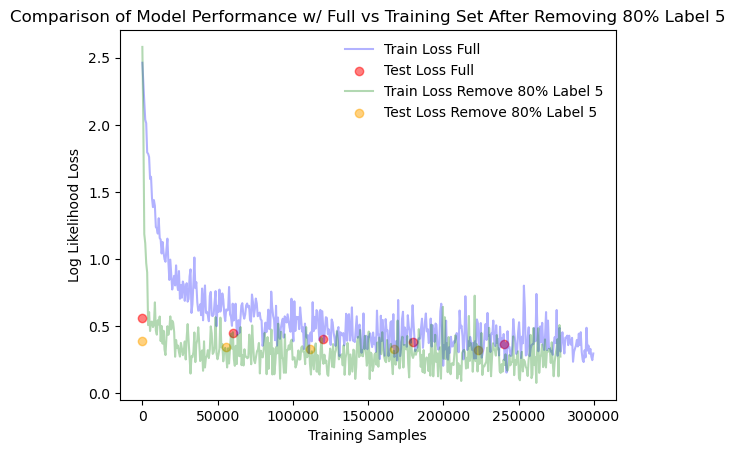

In [52]:
# plot the training and testing losses of the two rounds together
fig = pl.figure()
pl.plot(train_counter, train_losses_full, color="blue", alpha=0.3)
pl.scatter(test_counter[:-1], test_losses_full, color="red", alpha=0.5)
pl.plot(train_counter_remove_samples, train_losses_remove_samples, color="green", alpha=0.3)
pl.scatter(test_counter_remove_samples[:-1], test_losses_remove_samples, color="orange", alpha=0.5)


pl.legend(['Train Loss Full', 'Test Loss Full', 'Train Loss Remove 80% Label 5', 'Test Loss Remove 80% Label 5'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/ Full vs Training Set After Removing 80% Label 5")

pl.show()

According to this plot, the training and testing losses seem to decrease after removing 80% of the training samples that are labeled 5. 

In [53]:
correct_by_class_remove_samples = [0] * 10  
total_by_class_remove_samples = [0] * 10 # total samples

# Calculate per-class accuracy in testing set
with torch.no_grad():
    for data, target in test_loader:
        output_remove_samples = network_remove_samples(data.reshape(-1, 28*28))
        pred = output_remove_samples.data.max(1, keepdim=True)[1]

        for i in range(len(target)):
            total_by_class_remove_samples[target[i].item()] += 1
            if pred[i].item() == target[i].item(): # correct prediction
                correct_by_class_remove_samples[target[i].item()] += 1

class_accuracies_remove_samples = [
    correct_by_class_remove_samples[i] / total_by_class_remove_samples[i] if total_by_class_remove_samples[i] > 0 else 0
    for i in range(10)
]

for i, accuracy in enumerate(class_accuracies_remove_samples):
    print(f'Accuracy for class {i}: {accuracy * 100:.2f}%')

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_66660/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Accuracy for class 0: 98.37%
Accuracy for class 1: 97.62%
Accuracy for class 2: 90.12%
Accuracy for class 3: 92.48%
Accuracy for class 4: 93.18%
Accuracy for class 5: 67.49%
Accuracy for class 6: 95.72%
Accuracy for class 7: 91.83%
Accuracy for class 8: 90.14%
Accuracy for class 9: 89.10%


In [54]:
correct_by_class_full = [0] * 10
total_by_class_full = [0] * 10

# Calculate per-class accuracy for the full training set model in testing set
with torch.no_grad():
    for data, target in test_loader:
        output_full = network(data.reshape(-1, 28*28))
        pred = output_full.data.max(1, keepdim=True)[1]

        for i in range(len(target)):
            total_by_class_full[target[i].item()] += 1
            if pred[i].item() == target[i].item():
                correct_by_class_full[target[i].item()] += 1

class_accuracies_full = [
    correct_by_class_full[i] / total_by_class_full[i] if total_by_class_full[i] > 0 else 0
    for i in range(10)
]

for i, accuracy in enumerate(class_accuracies_full):
    print(f'Accuracy for class {i} (Full): {accuracy * 100:.2f}%')

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_66660/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Accuracy for class 0 (Full): 97.55%
Accuracy for class 1 (Full): 96.39%
Accuracy for class 2 (Full): 85.47%
Accuracy for class 3 (Full): 88.61%
Accuracy for class 4 (Full): 92.06%
Accuracy for class 5 (Full): 83.52%
Accuracy for class 6 (Full): 93.53%
Accuracy for class 7 (Full): 89.79%
Accuracy for class 8 (Full): 86.14%
Accuracy for class 9 (Full): 87.31%


In [81]:
(67.49 - 83.52)/83.52

-0.19193007662835251

We can see that the accuracy for label group 5 does decrease by 19%, which aligns with my intuition. However, the overall performance improves as the training and testing losses both decrease compared to the ones of the original model. In my opinion, this can be due to several reasons:
1. The model could be biased toward the classes with more samples, leading to better performance (lower errors) on these classes. 
2. The misclassifications of class 5 are not penalized heavily because of the lower count of class 5 samples. 

In [55]:
import matplotlib.pyplot as plt

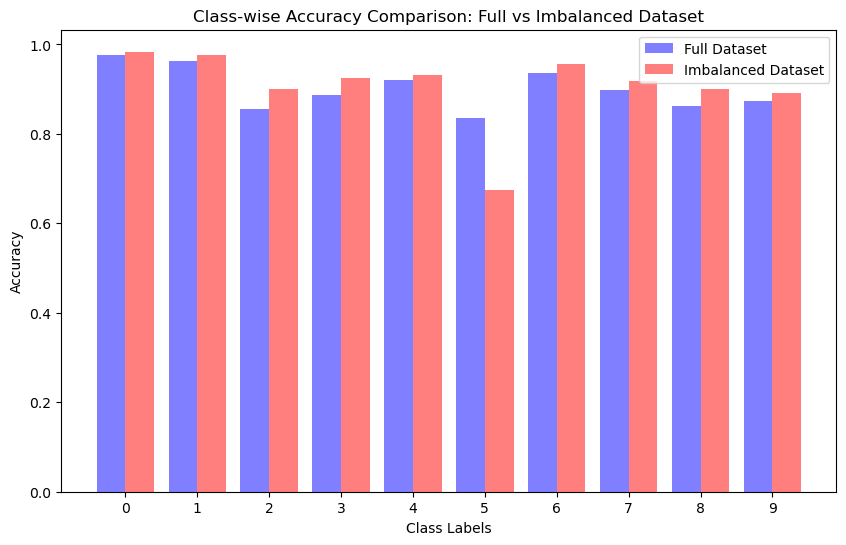

In [56]:
class_labels = list(range(10))

# Plot class-wise accuracy for the full dataset and the imbalanced dataset
plt.figure(figsize=(10,6))
plt.bar(class_labels, class_accuracies_full, width=0.4, label='Full Dataset', align='center', color='blue', alpha=0.5)
plt.bar([x + 0.4 for x in class_labels], class_accuracies_remove_samples, width=0.4, label='Imbalanced Dataset', align='center', color='red', alpha=0.5)

plt.xlabel('Class Labels')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy Comparison: Full vs Imbalanced Dataset')
plt.xticks([x + 0.2 for x in class_labels], class_labels)  # Center the ticks
plt.legend()
plt.show()

According to the bar plot, the accuracy of the model's prediction for samples labeled 5 drops significantly compared to other classes, meaning that the difference is **not homogenous** and is likely caused by the reduction of sample size in class 5.

#### 3. What happens if you change parameters like the learning rate and momentum? Plot the difference.

In my intuition, a higher learning rate will lead to a quicker convergence as it makes the model take larger steps during gradient descent; a higher momentum may help smooth out the fluctuations as it adds a larger contribution of the previous gradients to the model.

In [87]:
# original params:
# learning_rate = 0.001
# momentum = 0.1

parameters_set = {"learning_rate": [0.1, 0.01, 0.001],
                  "momentum": [0.1, 0.3, 0.5]}

parameter_results = {}
n_epochs = 5

In [88]:
def train_diff_params(network, optimizer, epoch, train_loader, dir):
    network.train()
    train_losses = []
    train_counter = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  
        output = network(data.reshape(-1, 28*28)) 
        loss = F.nll_loss(output, target)  
        loss.backward()  
        optimizer.step()  

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset)))
            
            torch.save(network.state_dict(), f'{dir}/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'{dir}/optimizer_iteration-{epoch}.pth')
    
    return train_losses, train_counter
# can be simplified by one general train func
    

In [89]:
def test_diff_params(network, test_loader):
    network.eval() 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.data.max(1, keepdim=True)[1]  
            correct += pred.eq(target.view_as(pred)).sum().item() 
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

    return test_loss, test_accuracy

In [90]:
import os

In [91]:
test_counter_diff_params = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [92]:
for lr in parameters_set['learning_rate']:
    for m in parameters_set['momentum']:
        print(f"Training with learning rate {lr} and momentum {m}")

        network = FeedforwardNeuralNetModel()
        optimizer = optim.SGD(network.parameters(), lr=lr, momentum=m)

        test_losses = []
        test_accuracies = []

        dir = f'./results_diff_params/results_lr_{lr}_momentum_{m}'  
        os.makedirs(dir, exist_ok=True) 
        
        train_counter = []
        train_losses = []
        
        for epoch in range(1, n_epochs + 1):
            tl, tc = train_diff_params(network, optimizer, epoch, train_loader, dir)
            test_loss, test_accuracy = test_diff_params(network, test_loader)
            
            train_counter.extend(tc)
            train_losses.extend(tl)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
        
        parameter_results[(lr, m)] = {
            'train_losses': train_losses,
            'train_counter': train_counter,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies
        }

Training with learning rate 0.1 and momentum 0.1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.440253
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.550218
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.644865


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_81600/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.291003
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.422711
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.370304
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.269564
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.354498
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.321683
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.336457
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.410747
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.341046
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.535740
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.352958
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.488073
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.408041
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.586809
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.330637
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.401865
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.511568
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.283237
Train Epoch: 1 [13440/60000 (22%)]	Loss: 0.190283
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.512677
Train Epoch: 1 [147

In [82]:
import pandas as pd

In [84]:
# ht_results = pd.read_csv('experiment_results.csv')

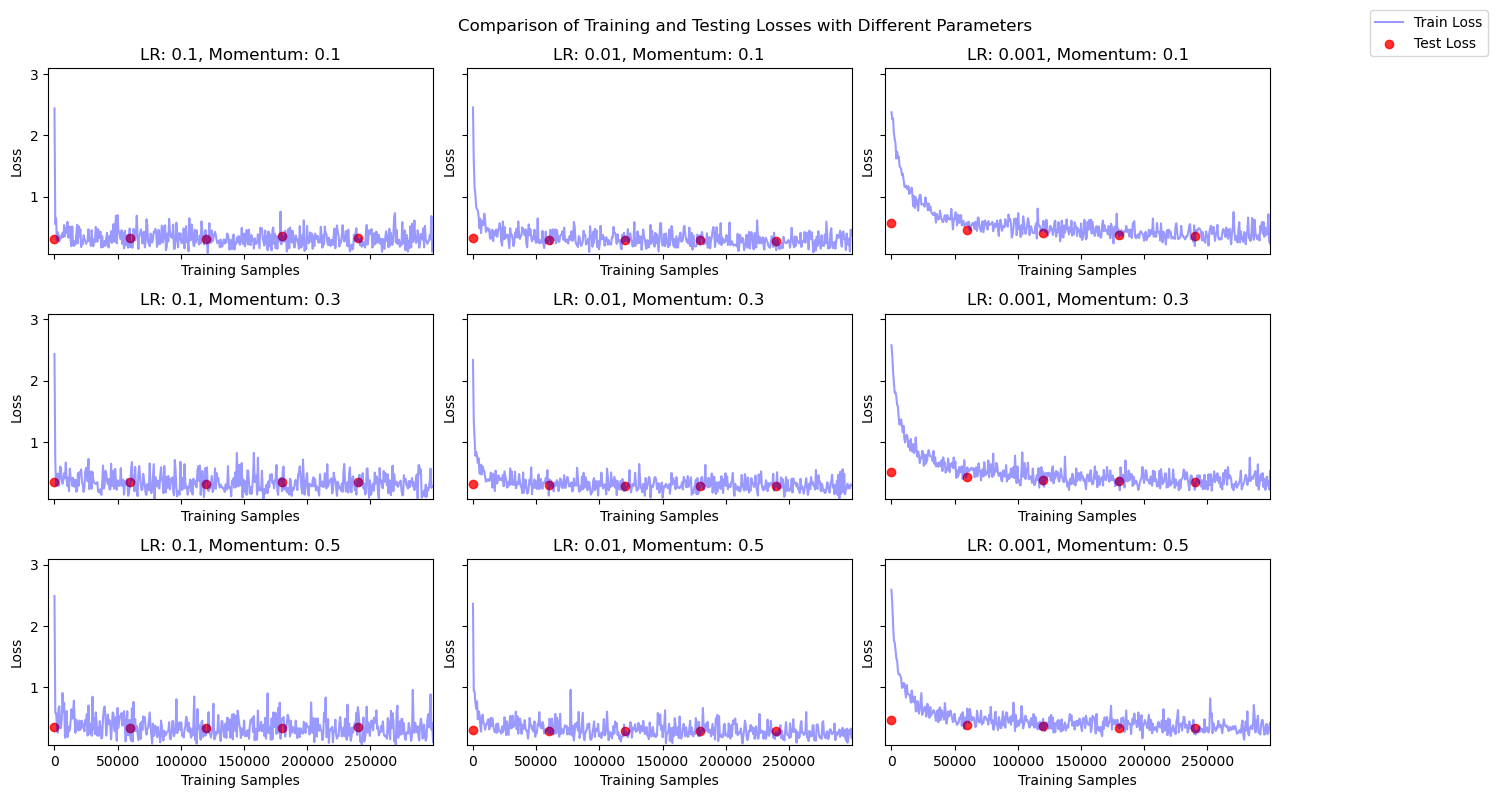

In [106]:
learning_rates = parameters_set['learning_rate']
momentums = parameters_set['momentum']

fig, axes = pl.subplots(len(momentums), len(learning_rates), figsize=(15, 8), sharex=True, sharey=True)
all_train_losses = [result['train_losses'] for result in parameter_results.values()]
all_test_losses = [result['test_losses'] for result in parameter_results.values()]
global_min_loss = min(map(min, all_train_losses + all_test_losses))
global_max_loss = max(map(max, all_train_losses + all_test_losses))
global_min_x = min(map(min, [result['train_counter'] for result in parameter_results.values()]))
global_max_x = max(map(max, [result['train_counter'] for result in parameter_results.values()]))

for i, m in enumerate(momentums):
    for j, lr in enumerate(learning_rates):
        ax = axes[i, j]
        
        ax.set_title(f'LR: {lr}, Momentum: {m}')
        ax.set_xlabel('Training Samples')
        ax.set_ylabel('Loss')
        
        if (lr, m) in parameter_results:
            result = parameter_results[(lr, m)]
            ax.plot(result['train_counter'], result['train_losses'], label='Train Loss', alpha=0.4, color='blue')
            ax.scatter(test_counter_diff_params[:-1], result['test_losses'], label='Test Loss', alpha=0.8, color='red')

        # Set the same x and y limits for all subplots
        ax.set_xlim(global_min_x - 5000, global_max_x)
        ax.set_ylim(global_min_loss, global_max_loss+0.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
fig.suptitle("Comparison of Training and Testing Losses with Different Parameters")

pl.tight_layout()
pl.subplots_adjust(right=0.85)
pl.show()

- As learning rate decrease (from left to right), the losses drop slower, especially during early training. This aligns with my intuition. This indicates that higher learning rate are associated with larger updates, which causes the model to converge quicker at first, but also brings more oscillations and instability.
- For all momentums, momentum 0.5 leads to the most stable training process. This is more noticable at a lower learning rate (the right column). The training and test losses converge smoothly, with minimal fluctuations, which matches my intuition. As momentum decreases (0.3 and 0.1), there are more oscillations. 
- However, the effects of learning rates on the smoothness of training process seem to be larger than the momentums. In my opinion, this may be attributed to the difference in magnitudes among the parameters chosen (for learning rates, I picked three that are 10 times different from each other; for momentum, I picked three that are an arithmetical sequence.)

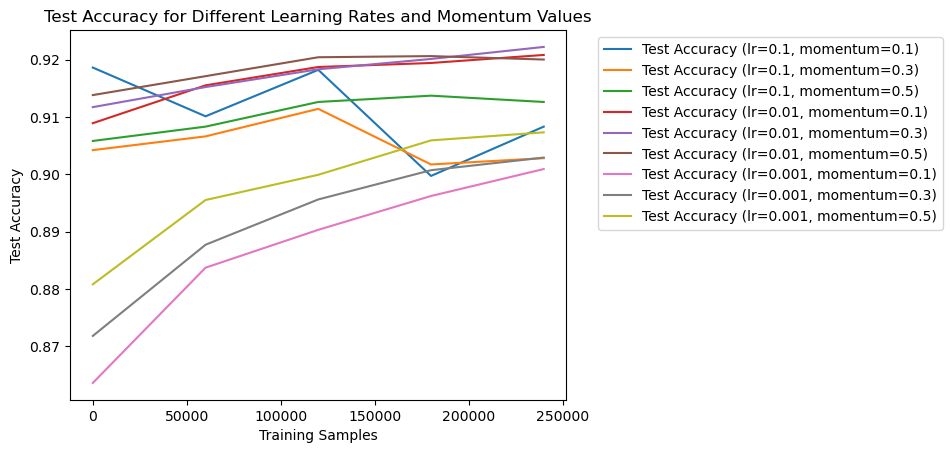

In [110]:
# Plotting testing accuracy of different combinations of parameters
fig = pl.figure()
for (lr, m), result in parameter_results.items():
    pl.plot(test_counter_diff_params[:-1], result['test_accuracies'], 
             label=f"Test Accuracy (lr={lr}, momentum={m})")

pl.xlabel('Training Samples')
pl.ylabel('Test Accuracy')
pl.title('Test Accuracy for Different Learning Rates and Momentum Values')
pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
pl.show()

The best performing configurations appear to be:
- Learning rate = 0.01, Momentum = 0.3 (purple line), which maintains strong and stable accuracy above 91%.
- Learning rate = 0.01, Momentum = 0.5 (brown line), which also shows stable performance around 91%.

The instable configurations:
- With learning rate = 0.1, no matter what the momentum is, the accuracy either fluctuates or dips as training progresses.

While higher learning rates can sometimes start strong, it may introduce instability, especially at lower momentums. On the other hand, if the learning rate is too low, it may start with low accuracy and high losses and cannot obtain good enough performance with certain limited training resources. In conclusion, we may have to test different combinations of parameters to achieve a both good and stable training process.


In [107]:
# save results
rows = []

for (lr, momentum), result in parameter_results.items():
    for epoch in range(n_epochs):
        rows.append({
            'learning_rate': lr,
            'momentum': momentum,
            'epoch': epoch + 1,
            'train_loss': result['train_losses'][epoch],
            'test_loss': result['test_losses'][epoch],
            'test_accuracy': result['test_accuracies'][epoch]
        })

# Convert list of dictionaries to DataFrame
df_results = pd.DataFrame(rows)

# Save the DataFrame to a CSV file
df_results.to_csv('experiment_results.csv', index=False)

print(df_results.head())

   learning_rate  momentum  epoch  train_loss  test_loss  test_accuracy
0            0.1       0.1      1    2.440253   0.300836         0.9186
1            0.1       0.1      2    0.550218   0.319479         0.9101
2            0.1       0.1      3    0.644865   0.306962         0.9182
3            0.1       0.1      4    0.291003   0.361982         0.8997
4            0.1       0.1      5    0.422711   0.327989         0.9083


#### 4. Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?

My intuition is that adding a hidden layer may improve the model performance, as it allows the model to learn more subtle details about the data. However, it also depends on the specific configureations chosen, like number of nodes and activation functions, and there is a risk of overfitting if no regularization is added. 

In [68]:
! mkdir -p results_hidden_layer_5
! mkdir -p results_hidden_layer_10

In [69]:
! mkdir -p results_10

In [70]:
class FeedforwardNeuralNetWithHiddenLayer(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        num_node_1 = 128
        super(FeedforwardNeuralNetWithHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_node_1)
        self.fc2 = nn.Linear(num_node_1, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))           
        x = self.fc2(x)                   
        return F.log_softmax(x, dim=1) 

In [71]:
network_hidden = FeedforwardNeuralNetWithHiddenLayer()
optimizer_hidden = optim.SGD(network_hidden.parameters(), lr=0.001, momentum=0.1)
# same params as original

n_epochs = 5
train_losses_hidden_5 = []
test_losses_hidden_5 = []
train_counter_hidden_5 = []
test_counter_hidden_5 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_hidden_5 = []

In [72]:
# use the train/test functions defined above
# train the hidden layer model for 5 epochs
for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_hidden, optimizer_hidden, epoch, train_loader, './results_hidden_layer_5'
    )
    test_loss, test_accuracy = test_diff_params(network_hidden, test_loader)

    train_counter_hidden_5.extend(tc)
    train_losses_hidden_5.extend(tl)
    
    test_losses_hidden_5.append(test_loss)
    test_accuracies_hidden_5.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.279999
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.256864
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.251526
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.208030
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.191804
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240419
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.237529
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.159178
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.174677
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.133976
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.146899
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.146646
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.077186
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.090760
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.079756
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.039092
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.001937
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.042419
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.994718
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.946460
Train Epoch: 1 [12800/60000 (

In [73]:
network_hidden_10 = FeedforwardNeuralNetWithHiddenLayer()
optimizer_hidden_10 = optim.SGD(network_hidden_10.parameters(), lr=0.001, momentum=0.1)
# same params as original

n_epochs = 10
train_losses_hidden_10 = []
test_losses_hidden_10 = []
train_counter_hidden_10 = []
test_counter_hidden_10 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_hidden_10 = []

# train the hidden layer model for 10 epochs
for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_hidden_10, optimizer_hidden_10, epoch, train_loader, './results_hidden_layer_10'
    )
    test_loss, test_accuracy = test_diff_params(network_hidden_10, test_loader)

    train_counter_hidden_10.extend(tc)
    train_losses_hidden_10.extend(tl)
    
    test_losses_hidden_10.append(test_loss)
    test_accuracies_hidden_10.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330210
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.362268
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.309426
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.268495
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.269877
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.265204
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.241191
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.161883
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.104667
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.155642
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.149630
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.140464
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.097117
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.094887
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.052577
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.980246
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.017901
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.058944
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.973870
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.012437
Train Epoch: 1 [12800/60000 (

In [74]:
# Train the original model for 10 epochs
network_10 = FeedforwardNeuralNetModel()
optimizer_10 = optim.SGD(network_10.parameters(), lr=0.001, momentum=0.1)
n_epochs = 10

train_losses_10 = []
train_counter_10 = []
test_losses_10 = []
test_counter_10 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_10 = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_10, optimizer_10, epoch, train_loader, './results_10'
    )
    test_loss, test_accuracy = test_diff_params(network_10, test_loader)

    train_counter_10.extend(tc)
    train_losses_10.extend(tl)
    
    test_losses_10.append(test_loss)
    test_accuracies_10.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.569214
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.327534
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.252681
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.152536


/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_66660/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.020401
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.995381
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.806210
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.798983
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.771170
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.508620
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.600908
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.504078
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.426762
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.391450
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.392438
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.261306
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.148770
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.351155
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.230380
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.197086
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.128553
Train Epoch: 1 [13440/60000 (22%)]	Loss: 1.132724
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.084294
Train Epoch: 1 [14720/60000 (25%)]	Loss: 1.120559
Train Epoch: 1 [1

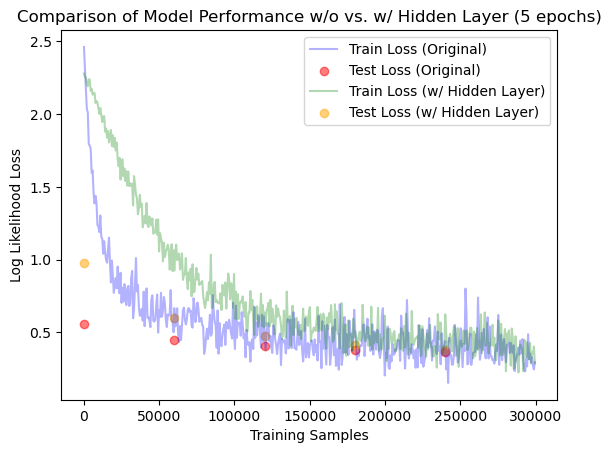

In [75]:
# compare training and testing losses w/ and w/o hidden layers (5 epoches)
fig = pl.figure()
pl.plot(train_counter, train_losses_full, color="blue", alpha=0.3, label="Train Loss (Original)")
pl.scatter(test_counter[:-1], test_losses_full, color="red", alpha=0.5, label="Test Loss (Original)")
pl.plot(train_counter_hidden_5, train_losses_hidden_5, color="green", alpha=0.3, label="Train Loss (w/ Hidden Layer)")
pl.scatter(test_counter_hidden_5[:-1], test_losses_hidden_5, color="orange", alpha=0.5, label="Test Loss (w/ Hidden Layer)")

pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/o vs. w/ Hidden Layer (5 epochs)")
pl.legend()

pl.show()

With in 5 epochs, the model with hidden layer seems to converge slower than the original model. Its testing accuracy also declines slower, and finally catches up with the original model at the last epoch. Now let's take a look at the model performance if given more training time.

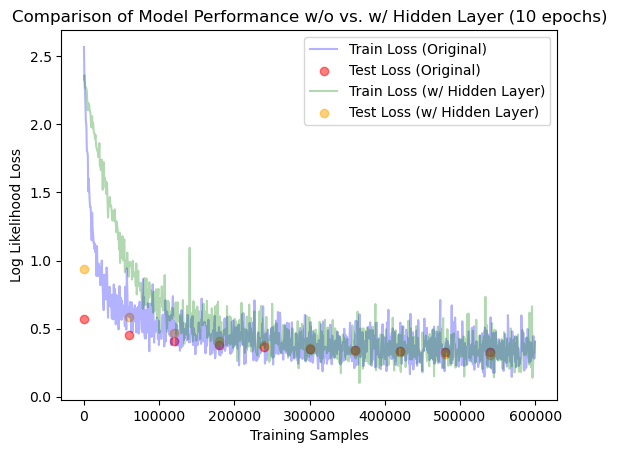

In [76]:
# compare training and testing losses w/ and w/o hidden layers (10 epoches)
fig = pl.figure()
pl.plot(train_counter_10, train_losses_10, color="blue", alpha=0.3, label="Train Loss (Original)")
pl.scatter(test_counter_10[:-1], test_losses_10, color="red", alpha=0.5, label="Test Loss (Original)")
pl.plot(train_counter_hidden_10, train_losses_hidden_10, color="green", alpha=0.3, label="Train Loss (w/ Hidden Layer)")
pl.scatter(test_counter_hidden_10[:-1], test_losses_hidden_10, color="orange", alpha=0.5, label="Test Loss (w/ Hidden Layer)")

pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/o vs. w/ Hidden Layer (10 epochs)")
pl.legend()

pl.show()

With 10 epochs, the training and testing losses of the model with hidden layer decrease slower than the original model, which indicates the hidden layer model has a slower learning process initially. This is because the hidden layer introduces more complexity and needs more data and time to optimize effectively. 

Despite that, the hidden layer model's performance improves steadily. As shown in the second comparison (with 10 epochs), the hidden layer model's training and testing losses catch up with the ones of the original model and eventually exceeds it. This proves that given enough training data and time, the hidden layer model can outperform the original model by learning more complex patterns and generalize better.

In [77]:
original_test_accuracies = parameter_results[(0.01,0.1)]['test_accuracies']

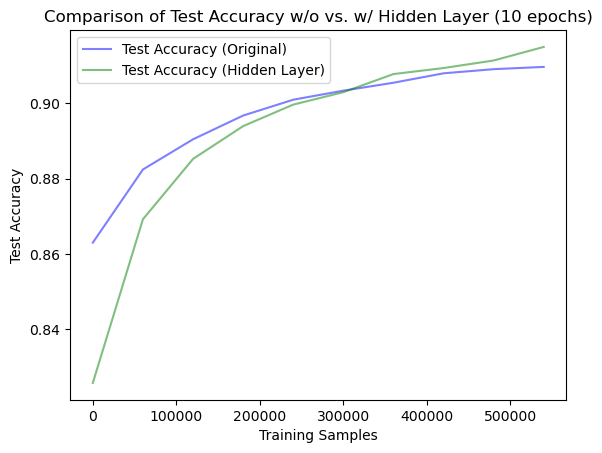

In [78]:
# compare test accuracies w/o and w/ hidden layer
fig = pl.figure()
plt.plot(test_counter_10[:-1], test_accuracies_10, label="Test Accuracy (Original)", color="blue", alpha=0.5)
plt.plot(test_counter_hidden_10[:-1], test_accuracies_hidden_10, label="Test Accuracy (Hidden Layer)", color="green", alpha=0.5)
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy w/o vs. w/ Hidden Layer (10 epochs)")
plt.legend()
plt.show()

The original model demonstrates a steadier increase in test accuracy in general, but plateaus after about 300k samples. The hidden layer model has a lower initial test accuracy, but increases more rapidly and surpasses the original model after about 300k samples. This confirms that the model with hidden layer have more capacity to learn the details of the data when given enough training samples and time. 

This observation matches the trend in losses showcased above, which reflect the hidden layer's traits of having a slower initial learning process as well as having more potential to learn complex patterns and generalize better. 

#### 5. Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?

My intuition is that the model will generalize better on the test set if we add regularization methods (meaning higher test accuracy) because they can help prevent overfitting.

Notes:
- L1: lasso
- L2: ridge
- Dropout: drops a fraction of neurons randomly during training

In [79]:
! mkdir -p results_l1_reg
! mkdir -p results_l2_reg
! mkdir -p results_dropout_reg
! mkdir -p results_no_reg

In [80]:
n_epochs = 5

In [81]:
# model with no regularization (I increased the learning rate compared to the original one)

network_no_reg = FeedforwardNeuralNetModel()
optimizer_no_reg = optim.SGD(network_no_reg.parameters(), lr=0.05, momentum=0.1)

train_losses_no_reg = []
train_counter_no_reg = []
test_losses_no_reg = []
test_counter_no_reg = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_no_reg = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_no_reg, optimizer_no_reg, epoch, train_loader, './results_no_reg'
    )
    test_loss, test_accuracy = test_diff_params(network_no_reg, test_loader)

    train_counter_no_reg.extend(tc)
    train_losses_no_reg.extend(tl)
    
    test_losses_no_reg.append(test_loss)
    test_accuracies_no_reg.append(test_accuracy)

/var/folders/rl/hnl6k6053sxb72xb666_fj5r0000gn/T/ipykernel_66660/186602782.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out) # log prob


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.410441
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.917874
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.483751
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.510991
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.701146
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.370039
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.263081
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.415313
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.390256
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.298252
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.246775
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.275215
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.560654
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.295155
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.373170
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.617941
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.458470
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.365314
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.357968
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.332732
Train Epoch: 1 [12800/60000 (

In [82]:
# add L1
def l1_penalty(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

l1_lambda = 0.01  

def train_with_l1(network, optimizer, epoch, train_loader, dir):
    network.train()

    train_losses = []
    train_counter = []

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data.view(-1, 28*28))  # Flatten input images
        loss = F.nll_loss(output, target)  
        loss += l1_penalty(network, l1_lambda)  # Add L1 penalty to loss
        loss.backward()  
        optimizer.step()  
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset))
            )

            torch.save(network.state_dict(), f'{dir}/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'{dir}/optimizer_iteration-{epoch}.pth')
    
    return train_losses, train_counter

network_l1 = FeedforwardNeuralNetWithHiddenLayer()
optimizer_l1 = optim.SGD(network_l1.parameters(), lr=0.05, momentum=0.1)

train_losses_l1 = []
test_losses_l1 = []
train_counter_l1 = []
test_counter_l1 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_l1 = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_with_l1(network_l1, optimizer_l1, epoch, train_loader, './results_l1_reg')
    test_loss, test_accuracy = test_diff_params(network_l1, test_loader)

    train_counter_l1.extend(tc)
    train_losses_l1.extend(tl)

    test_losses_l1.append(test_loss)
    test_accuracies_l1.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 20.879953
Train Epoch: 1 [640/60000 (1%)]	Loss: 15.125035
Train Epoch: 1 [1280/60000 (2%)]	Loss: 10.549761
Train Epoch: 1 [1920/60000 (3%)]	Loss: 7.288121
Train Epoch: 1 [2560/60000 (4%)]	Loss: 5.040768
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3.625729
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.852112
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.565041
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.612908
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.499370
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.239539
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.186524
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.169182
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.086633
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.044901
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.050091
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.928724
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.898115
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.024393
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.957631
Train Epoch: 1 [12800/6000

In [83]:
# add L2
network_l2 = FeedforwardNeuralNetWithHiddenLayer()
optimizer_l2 = optim.SGD(network_l2.parameters(), lr=0.05, momentum=0.1, weight_decay=0.01)

train_losses_l2 = []
test_losses_l2 = []
train_counter_l2 = []
test_counter_l2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_l2 = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_with_l1(network_l2, optimizer_l2, epoch, train_loader, './results_l2_reg')
    test_loss, test_accuracy = test_diff_params(network_l2, test_loader)

    train_counter_l2.extend(tc)
    train_losses_l2.extend(tl)

    test_losses_l2.append(test_loss)
    test_accuracies_l2.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 20.897221
Train Epoch: 1 [640/60000 (1%)]	Loss: 15.143381
Train Epoch: 1 [1280/60000 (2%)]	Loss: 10.532821
Train Epoch: 1 [1920/60000 (3%)]	Loss: 7.206995
Train Epoch: 1 [2560/60000 (4%)]	Loss: 4.760021
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3.456594
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.638011
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.464635
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.271968
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.373691
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.201281
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.007234
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.964455
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.056077
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.983213
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.842360
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.837528
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.922892
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.699312
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.693550
Train Epoch: 1 [12800/6000

In [84]:
# add drop-out
class FeedforwardNeuralNetWithDropout(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        num_nodes = 128
        dropout_rate = 0.2

        super(FeedforwardNeuralNetWithDropout, self).__init__()
        # Input layer: 28*28 -> Hidden layer
        self.fc1 = nn.Linear(input_dim, num_nodes)
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate) 
        # Hidden layer -> Output layer
        self.fc2 = nn.Linear(num_nodes, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
network_dropout = FeedforwardNeuralNetWithDropout()
optimizer_dropout = optim.SGD(network_dropout.parameters(), lr=0.05, momentum=0.1)

# Train the model with dropout regularization
train_losses_dropout = []
test_losses_dropout = []
train_counter_dropout = []
test_counter_dropout = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_dropout = []

for epoch in range(1, n_epochs + 1):
    tl, tc = train_diff_params(
        network_dropout, optimizer_dropout, epoch, train_loader, './results_dropout_reg'
    )
    test_loss, test_accuracy = test_diff_params(network_dropout, test_loader)

    train_counter_dropout.extend(tc)
    train_losses_dropout.extend(tl)

    test_losses_dropout.append(test_loss)
    test_accuracies_dropout.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.358081
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.658706
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.192701
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.772421
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.974592
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.627054
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.823096
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.775662
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.808374
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.752510
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.638318
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.424380
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.728602
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.493148
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.473892
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.531855
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.589635
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.323665
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.429984
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.514678
Train Epoch: 1 [12800/60000 (

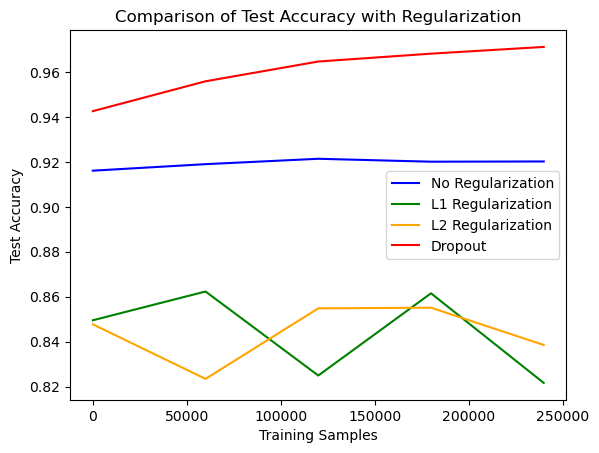

In [85]:
# Plot comparison of test accuracy with different regularizations
fig = plt.figure()
plt.plot(test_counter_no_reg[:-1], test_accuracies_no_reg, label="No Regularization", color="blue")
plt.plot(test_counter_l1[:-1], test_accuracies_l1, label="L1 Regularization", color="green")
plt.plot(test_counter_l2[:-1], test_accuracies_l2, label="L2 Regularization", color="orange")
plt.plot(test_counter_dropout[:-1], test_accuracies_dropout, label="Dropout", color="red")
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy with Regularization")
plt.legend()
plt.show()

This partially confirms my intuition. Dropout is successful in achieving higher test accuracy, while the other two regularizations, L1 and L2, aren't.

In this plot, dropout achieves the highest test accuracy, consistently improving as the training samples increase. By the end of training, it reaches an accuracy of about 0.97, which means t**he dropout regularization helps the model to generalize better and prevents overfitting**. The no regularization model have a relatively high accuracy, but does not improve too much after about 100k sampels. Both L1 and L2 regularized model show fluctuating test accuracies, which may suggest that these regularization techniques are not as effective in this case.

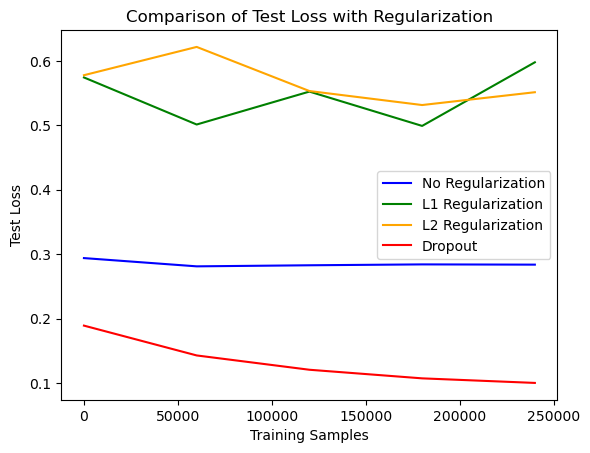

In [86]:
# Comparison of test loss with regularizations
fig = plt.figure()
plt.plot(test_counter_no_reg[:-1], test_losses_no_reg, label="No Regularization", color="blue")
plt.plot(test_counter_l1[:-1], test_losses_l1, label="L1 Regularization", color="green")
plt.plot(test_counter_l2[:-1], test_losses_l2, label="L2 Regularization", color="orange")
plt.plot(test_counter_dropout[:-1], test_losses_dropout, label="Dropout", color="red")
plt.xlabel("Training Samples")
plt.ylabel("Test Loss")
plt.title("Comparison of Test Loss with Regularization")
plt.legend()
plt.show()

The dropout model has the lowest test loss across all models. In the end, the test loss reaches 0.1, suggesting the regularization helps to reduce overfitting and the model fits the unseen data relatively well. The test loss for the model without regularization remains relatively high, which suggests that the model is not as efficient as minimizing loss as the dropout model. Both L1 and L2 regularization models show higher test losses which fluctuate more, indicating that these regularizations may be over-penalizing the model's weights.

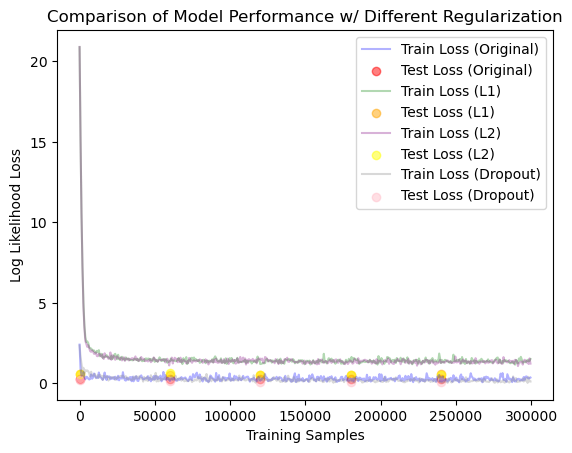

In [87]:
# compare training and testing losses w/ different regularization
fig = pl.figure()
pl.plot(train_counter_no_reg, train_losses_no_reg, color="blue", alpha=0.3, label="Train Loss (Original)")
pl.scatter(test_counter_no_reg[:-1], test_losses_no_reg, color="red", alpha=0.5, label="Test Loss (Original)")

pl.plot(train_counter_l1, train_losses_l1, color="green", alpha=0.3, label="Train Loss (L1)")
pl.scatter(test_counter_l1[:-1], test_losses_l1, color="orange", alpha=0.5, label="Test Loss (L1)")

pl.plot(train_counter_l2, train_losses_l2, color="purple", alpha=0.3, label="Train Loss (L2)")
pl.scatter(test_counter_l2[:-1], test_losses_l2, color="yellow", alpha=0.5, label="Test Loss (L2)")

pl.plot(train_counter_dropout, train_losses_dropout, color="gray", alpha=0.3, label="Train Loss (Dropout)")
pl.scatter(test_counter_dropout[:-1], test_losses_dropout, color="pink", alpha=0.5, label="Test Loss (Dropout)")

pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')
pl.title("Comparison of Model Performance w/ Different Regularization")
pl.legend()

pl.show()

Dropout continues to show the best overall performance both in terms of training and testing losses. L1 and L2 show higher training and testing losses, suggesting they may not be very suitable to improve the model. The no regularization model also performs relatively well in terms of training and testing losses. 

#### 6. [stretch] Can you change this model and turn it into a convolutional neural network?

Notes:
- `in_channels`: input size
- `out_channels`: num of filters to apply (num of feature maps generated)
- `kernal_size`: size of sliding window

In [88]:
! mkdir -p results_cnn

In [89]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layers
        # 1-channel input b/c grayscale image (this was suggested by ChatGPT)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) # out: 10 diff 12x12 after 2x2 max pooling
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5) # out: 20 diff 4x4 after 2x2 max pooling
        
        # Dropout layer to avoid overfitting (this was suggested by ChatGPT)
        self.conv2_drop = nn.Dropout2d()

        # dense layers
        self.fc1 = nn.Linear(320, 50) # 20x4x4
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # conv1 followed by ReLU and max pooling 2x2
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # conv2 followed by ReLU, dropout, and max pooling 2x2
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # dropout for dense layer
        x = F.log_softmax(self.fc2(x), dim=1) 
        return x

In [90]:
def train_cnn(network, optimizer, epoch, train_loader, dir):
    network.train()
    train_losses = []
    train_counter = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  
        output = network(data.view(-1, 1, 28, 28))
        loss = F.nll_loss(output, target)  
        loss.backward()  
        optimizer.step()  

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            train_losses.append(loss.item())
            train_counter.append((batch_idx * len(data)) + ((epoch - 1) * len(train_loader.dataset)))
            
            torch.save(network.state_dict(), f'{dir}/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'{dir}/optimizer_iteration-{epoch}.pth')
    
    return train_losses, train_counter

def test_cnn(network, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): 
        for data, target in test_loader:
            output = network(data.view(-1, 1, 28, 28))
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')

    return test_loss, test_accuracy

In [91]:
cnn = CNN() 
optimizer_cnn = optim.SGD(cnn.parameters(), lr=0.05, momentum=0.1)

In [92]:
n_epochs = 5

train_losses_cnn = []
train_counter_cnn = []
test_losses_cnn = []
test_counter_cnn = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_accuracies_cnn = []

In [93]:
for epoch in range(1, n_epochs + 1):
    tl, tc = train_cnn(
        cnn, optimizer_cnn, epoch, train_loader, './results_cnn'
    )
    test_loss, test_accuracy = test_cnn(cnn, test_loader)

    train_counter_cnn.extend(tc)
    train_losses_cnn.extend(tl)
    
    test_losses_cnn.append(test_loss)
    test_accuracies_cnn.append(test_accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.392691
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.275208
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.186794
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.011646
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.759619
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.612895
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.279947
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.256452
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.889641
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.082552
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.975873
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.976830
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.849182
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.623183
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.609488
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.222020
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.926669
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.923560
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.822177
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.447690
Train Epoch: 1 [12800/60000 (

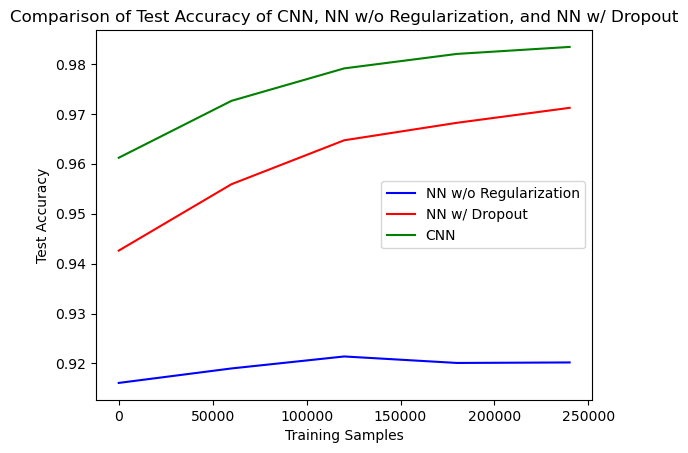

In [94]:
# compare performance with original model & original model with dropout

# Test accuracy comparison
fig = plt.figure()
plt.plot(test_counter_no_reg[:-1], test_accuracies_no_reg, label="NN w/o Regularization", color="blue")
plt.plot(test_counter_dropout[:-1], test_accuracies_dropout, label="NN w/ Dropout", color="red")
plt.plot(test_counter_cnn[:-1], test_accuracies_cnn, label="CNN", color="green")
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy of CNN, NN w/o Regularization, and NN w/ Dropout")
plt.legend()
plt.show()

The CNN achieves the highest test accuracy, exceeding 98% after 200k training samples and outperforming the neural networks with dense layers significantly. The demonstartes the CNN's ability to generalize on image data compared to fully connected neural networks. 

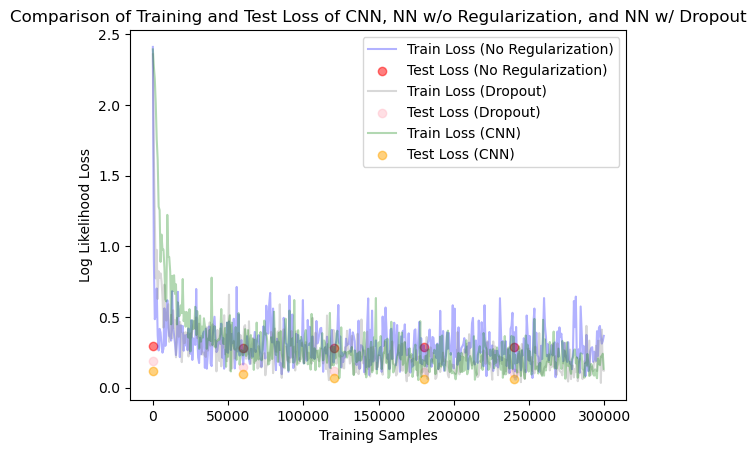

In [95]:
# training and testing losses comparison
fig = plt.figure()
plt.plot(train_counter_no_reg, train_losses_no_reg, color="blue", alpha=0.3, label="Train Loss (No Regularization)")
plt.scatter(test_counter_no_reg[:-1], test_losses_no_reg, color="red", alpha=0.5, label="Test Loss (No Regularization)")

pl.plot(train_counter_dropout, train_losses_dropout, color="gray", alpha=0.3, label="Train Loss (Dropout)")
pl.scatter(test_counter_dropout[:-1], test_losses_dropout, color="pink", alpha=0.5, label="Test Loss (Dropout)")

plt.plot(train_counter_cnn, train_losses_cnn, color="green", alpha=0.3, label="Train Loss (CNN)")
plt.scatter(test_counter_cnn[:-1], test_losses_cnn, color="orange", alpha=0.5, label="Test Loss (CNN)")

plt.xlabel('Training Samples')
plt.ylabel('Log Likelihood Loss')
plt.title("Comparison of Training and Test Loss of CNN, NN w/o Regularization, and NN w/ Dropout")
plt.legend()

plt.show()

The convolutional neural network have slowest-decreasing training loss at the beginning but consistently decrease over time, almost outperforming the neural networks with only dense layers in the end. The CNN's testing losses remain the lowest at every checkpoint, indicating that the convolutional layers and regularization together learn the data well and generalize effectively to unseen data. 

In conclusion, CNN outperforms the fully connected networks in both accuracy and loss. Dropout regularization helps the fully connected network improve its generalization, but it still doesn’t reach the performance of CNN.

#### Acknowledgement

I would like to acknowledge the assistance of OpenAI's ChatGPT in providing guidance and suggestions on implementing the regularization methods and the CNN in question 5 and 6 of the final challenges.